In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

In [2]:
from src.optimizers.agmsdr import AGMsDR
from src.example_functions import NormX2N, SumOfExponents
import time
import numpy as np
import torch
from tqdm import tqdm

In [3]:
def experiment(x0, function, optimizer, max_iters=1000, tol=1e-18, verbose=False):
    start_time = time.time()
    x = torch.tensor(x0, dtype=torch.float32, requires_grad=True)
    optimizer_instance = optimizer([x])
    
    loss_history = []
    
    # Флаг для контроля backward
    compute_grad = [True]
    
    def closure(backward=True):
        loss = function.f(x)
        if backward and compute_grad[0] and loss.requires_grad:
            optimizer_instance.zero_grad()
            loss.backward()
        return loss
    loss_history.append(closure().item())
    for i in tqdm(range(max_iters), desc="Iterations") if verbose else range(max_iters):
        # ACDM handles backward internally, so don't do it in closure
        from src.optimizers.acdm import ACDM
        compute_grad[0] = not isinstance(optimizer_instance, ACDM)
        
        loss = optimizer_instance.step(closure)
        if loss is None:
            loss = closure()
        loss_history.append(loss.item())

    end_time = time.time()
    elapsed_time = end_time - start_time
    return x.detach().numpy(), loss_history, elapsed_time

In [4]:
n_dim = 10
max_iters = 300
x0 = torch.randn(n_dim)
x0 /= torch.norm(x0)

results = {}

for p in [4, 6, 8, 24]:
    func = NormX2N(n=p // 2)
    results[p] = {}
    for L1 in [1, 2, 4, 8, 16, 32, 64]:
        func.L1 = L1
        func.L0 = ((p-2)/L1) ** (p-2)

        x, loss_history, elapsed_time = experiment(x0.clone(), func, lambda params: AGMsDR(params, L0=func.L0, L1=func.L1), max_iters=max_iters, verbose=False)
        print(f'{p=}\t{L1=}\tfinal_loss: {loss_history[-1]}')
        results[p][L1] = {
            "x": x,
            "loss_history": loss_history,
            "elapsed_time": elapsed_time
        }

C:\Users\volan\AppData\Local\Temp\ipykernel_8004\429649277.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x0, dtype=torch.float32, requires_grad=True)


p=4	L1=1	final_loss: 5.433702426671516e-06


C:\Users\volan\AppData\Local\Temp\ipykernel_8004\429649277.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x0, dtype=torch.float32, requires_grad=True)


p=4	L1=2	final_loss: 3.4485603350731253e-07
p=4	L1=4	final_loss: 2.2116950049166917e-08
p=4	L1=8	final_loss: 1.453388298600089e-09
p=4	L1=16	final_loss: 1.0040079878592678e-10
p=4	L1=32	final_loss: 7.685135514079455e-12
p=4	L1=64	final_loss: 7.380178824838157e-13
p=6	L1=1	final_loss: 0.00994073785841465
p=6	L1=2	final_loss: 0.00017894574557431042
p=6	L1=4	final_loss: 2.857452955140616e-06
p=6	L1=8	final_loss: 4.609355386264724e-08
p=6	L1=16	final_loss: 7.677124491678455e-10
p=6	L1=32	final_loss: 1.3720756301960346e-11
p=6	L1=64	final_loss: 2.9032689880664764e-13
p=8	L1=1	final_loss: 0.22640995681285858
p=8	L1=2	final_loss: 0.023228473961353302
p=8	L1=4	final_loss: 0.00011601510777836666
p=8	L1=8	final_loss: 4.668469557600474e-07
p=8	L1=16	final_loss: 1.9271324536163092e-09
p=8	L1=32	final_loss: 8.464892849169292e-12
p=8	L1=64	final_loss: 7.05670737772765e-14
p=24	L1=1	final_loss: 0.08333321660757065
p=24	L1=2	final_loss: 0.08333321660757065
p=24	L1=4	final_loss: 0.08333321660757065
p=2

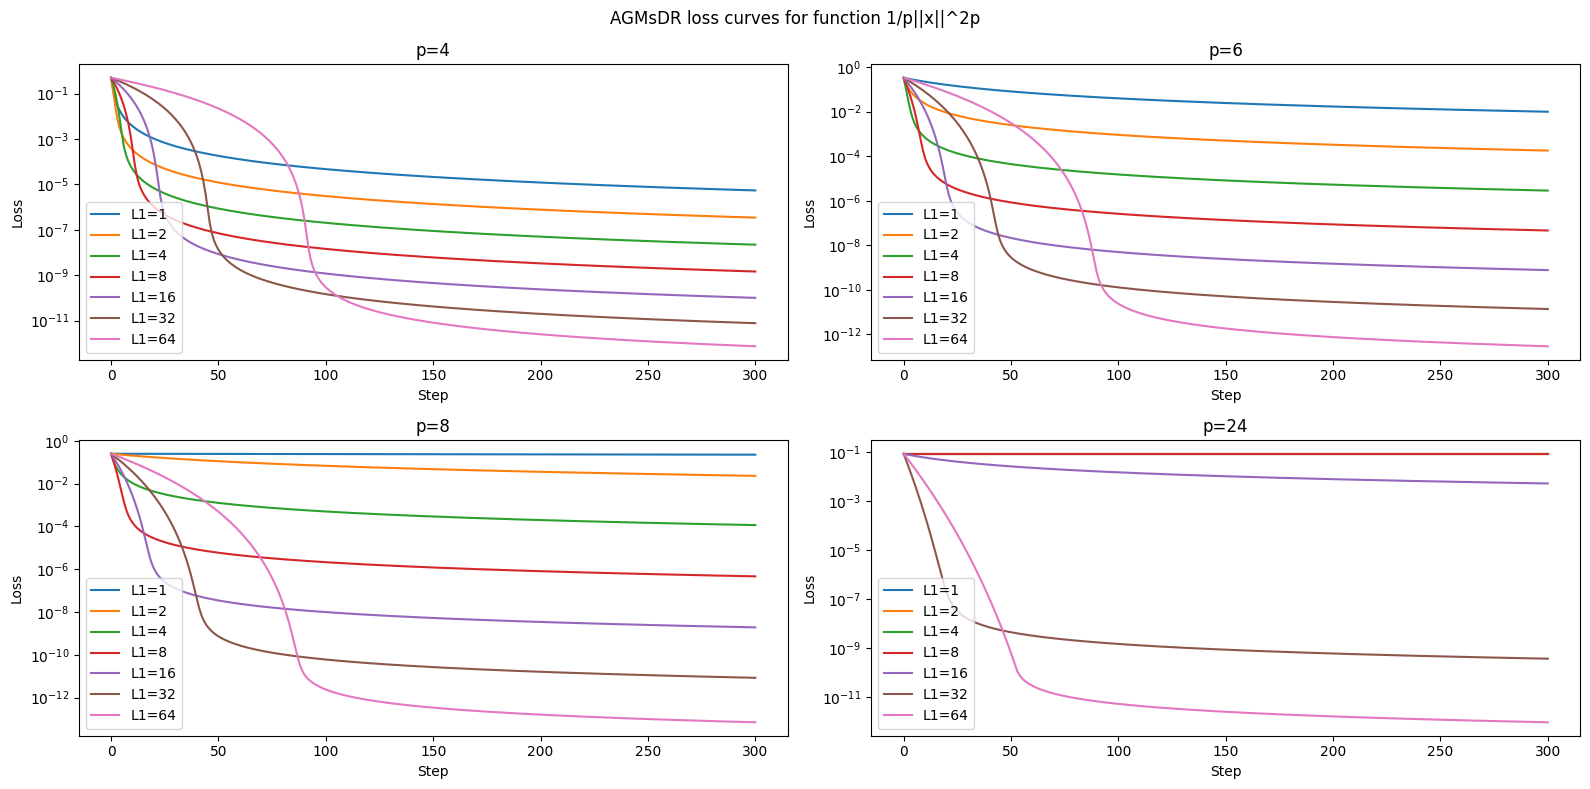

In [5]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle('AGMsDR loss curves for function 1/p||x||^2p')
for i, p in enumerate([4, 6, 8, 24]):
    for L1 in sorted(results[p]):
        axs[i // 2, i % 2].plot(results[p][L1]["loss_history"], label=f"L1={L1}")
        axs[i // 2, i % 2].set_title(f"p={p}")
        axs[i // 2, i % 2].legend()
        axs[i // 2, i % 2].set_ylabel("Loss")
        axs[i // 2, i % 2].set_xlabel("Step")
        axs[i // 2, i % 2].set_yscale("log")
        # axs[i // 2, i % 2].set_xscale("log")
fig.tight_layout()